# LAB 11 : Generative Adversarial Networks

Name : 

Roll Number :

References : 

  1. https://towardsdatascience.com/gans-from-scratch-8f5da17b3fb4

#**Problem 1** : Understanding and Training Vanilla GANs  

1. Consider MNIST Digit Dataset
2. Create a Generator and a Discriminator Network and train the network. Follow this article : https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f
3. Explain briefly about your understanding of GANs

##Write down the Objectives, Hypothesis and Experimental description for the above problem


Generative Adversarial Networks (or GANs ) are one of the most popular Machine Learning algorithms 

*   They belong to the set of algorithms named generative models.
*   These algorithms belong to the field of unsupervised learning

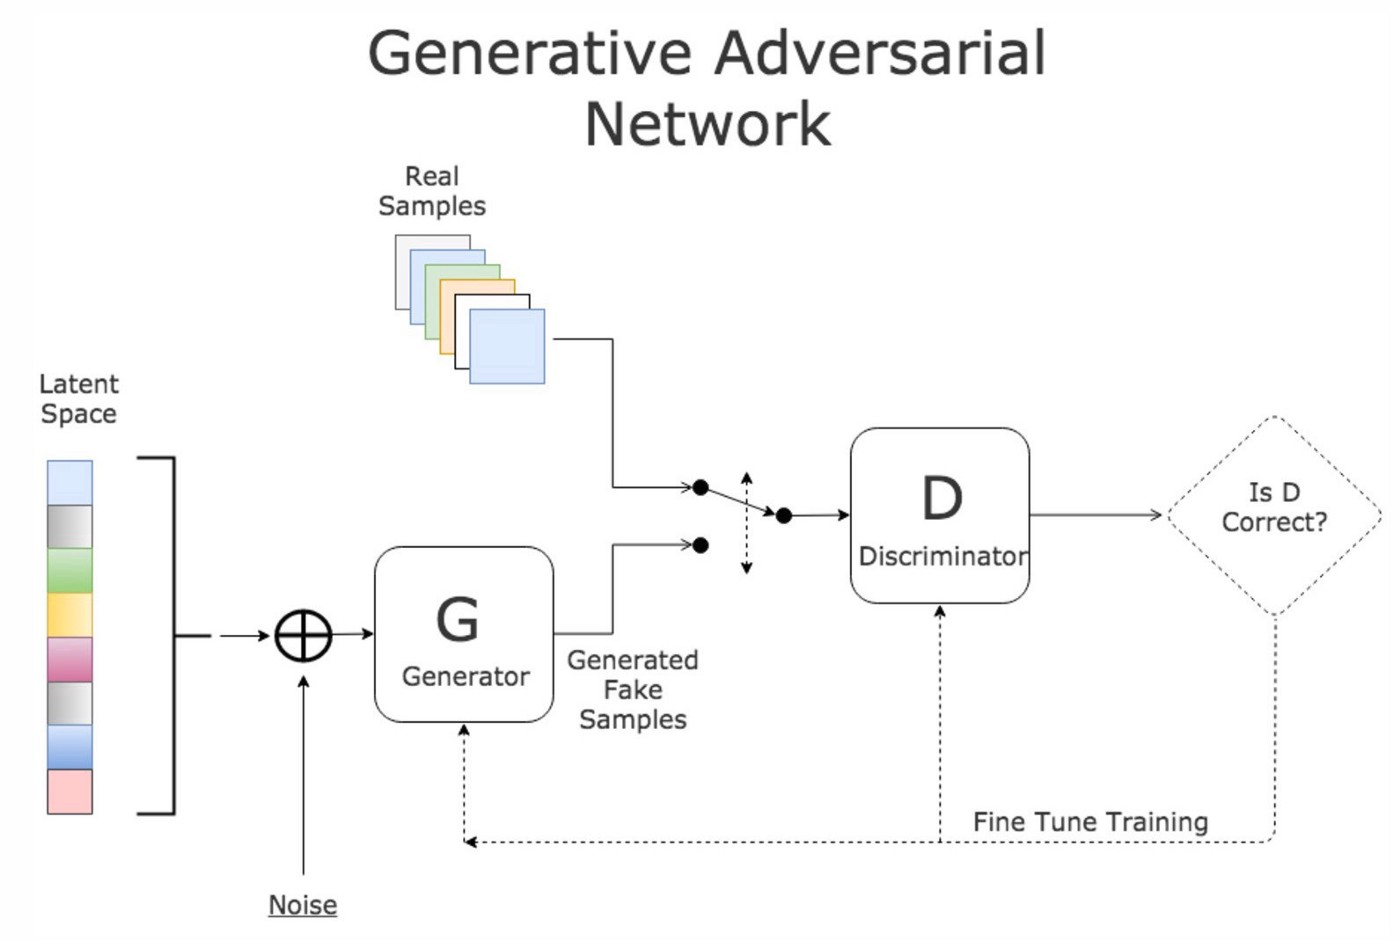


Generative Adversarial Networks are composed of two models:

* The first model is called a Generator and it aims to generate new data similar to the expected one. The Generator could be asimilated to a human art forger, which creates fake works of art.
* The second model is named the Discriminator. This model’s goal is to recognize if an input data is ‘real’ — belongs to the original dataset — or if it is ‘fake’ — generated by a forger. In this scenario, a Discriminator is analogous to an art expert, which tries to detect artworks as truthful or fraud.

The Generator (forger) needs to learn how to create data in such a way that the Discriminator isn’t able to distinguish it as fake anymore.

## Programming : 
  Please write a program to demonstrate the same

In [1]:
## Write your code here
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [2]:
# Preprocessing

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

# Set the dimensions of the noise
z_dim = 100

In [8]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

g = Sequential()
g.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(784, activation='sigmoid'))  # Values between 0 and 1
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

d = Sequential()
d.add(Dense(1024, input_dim=784, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    #d_acc = [v[1] for v in losses["D"]]
    #g_acc = [v[1] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    #plt.plot(d_acc, label="Discriminator accuracy")
    #plt.plot(g_acc, label="Generator accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [10]:
# Set up a vector (dict) to store the losses
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):  # tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Generate the images from the noise
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final batch of epoch
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 200
Batch size: 128
Batches per epoch: 468


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/200 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


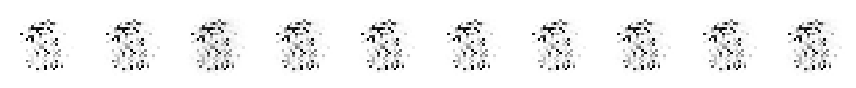

--------------- Epoch 20 ---------------


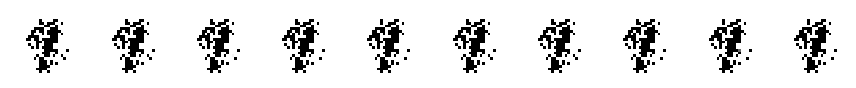

--------------- Epoch 40 ---------------


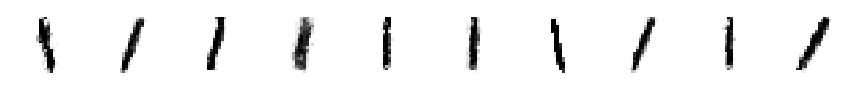

--------------- Epoch 60 ---------------


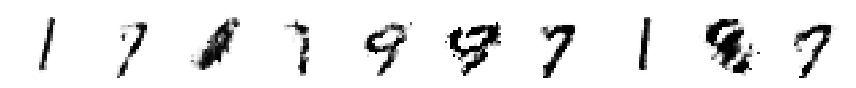

--------------- Epoch 80 ---------------


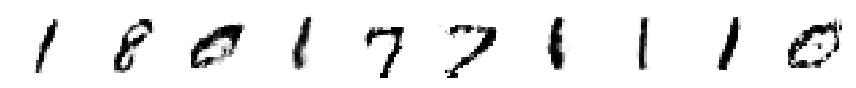

--------------- Epoch 100 ---------------


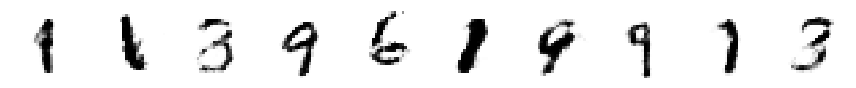

--------------- Epoch 120 ---------------


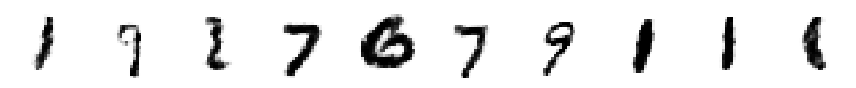

--------------- Epoch 140 ---------------


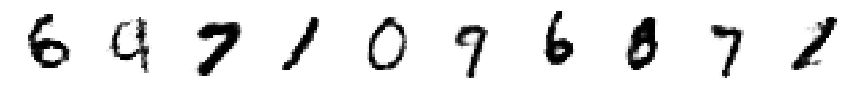

--------------- Epoch 160 ---------------


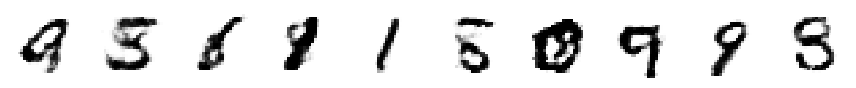

--------------- Epoch 180 ---------------


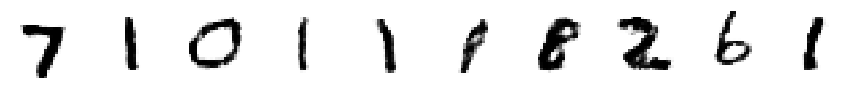

--------------- Epoch 200 ---------------


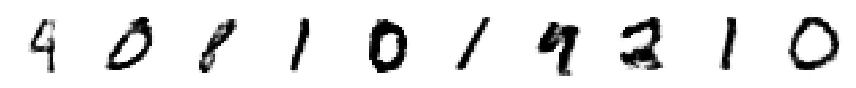

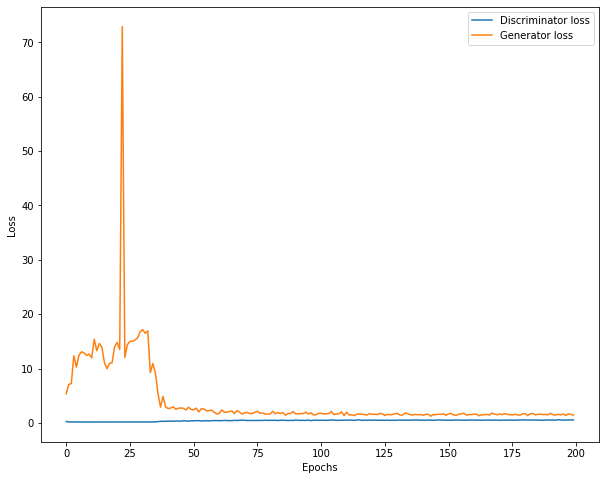

In [11]:
train(epochs=200, plt_frq=20, BATCH_SIZE=128)

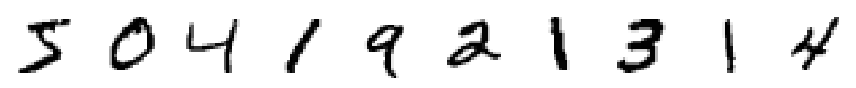

In [5]:
plt.figure(figsize=(12,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape(28,28), interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

## Inferences and Conclusion : State all the key observations and conclusion

For initial epoches generator images are easily distinguishable from the real images. (About 50 epoches)

But after that some digits generated are very similar to the real images. (Mostly digit 1)

Till 100 epoches it can generate almost all digits very similar to the real ones, which reduces the loss very near to 0.

It still can't generate some digit very clearly. (Its getting confused in 4 and 9 so generate some mixed digit)

